In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import LabelEncoder






In [3]:
df = pd.read_csv('Experiment_3.csv')
df

,RSSI-Value,MAC-Address,Timestamp,Distance
0,-19,F0:79:C0:40:FB:93,2024-09-12 09:45:00,0.0
1,-18,EA:25:00:4F:3C:4D,2024-09-12 09:45:00,0.0
2,-21,EF:0D:1E:F2:0C:B2,2024-09-12 09:45:01,0.0
3,-19,CB:08:AA:AA:C9:C6,2024-09-12 09:45:01,0.0
4,-19,ED:4F:A6:06:39:7A,2024-09-12 09:45:01,0.0
...,...,...,...,...
5864,-76,FB:E4:DE:81:2E:36,2024-09-12 10:57:56,10.0
5865,-85,FA:91:73:AF:B5:AA,2024-09-12 10:57:57,10.0
5866,-79,ED:4F:A6:06:39:7A,2024-09-12 10:57:57,10.0
5867,-80,EA:25:00:4F:3C:4D,2024-09-12 10:57:58,10.0


## Data Preprocessing

### Add LODPM values in a clumn

As a first step a new column distance according to paper (DATP) is appended to the frame. It is computed with according to the Log-Distance Path Loss Model, using the free space constant and the mean RSSI value mesaured at distance 1m. Also the RSSI-value column is being reshaped from INT to float.

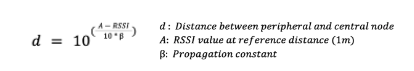

In [4]:

def distance_formula(rssi, n, Tx): # formula to calculate the distance according to the paper
    return 10 ** ((rssi - Tx) / (-10 * n))

propagation_constant = 2
mean_rssi_1m = -64.56
df['DATP'] = distance_formula(df['RSSI-Value'], propagation_constant, mean_rssi_1m)


df['RSSI-Value'] = df['RSSI-Value'].values.reshape(-1,1).astype(float)


### Balance Data

As a second step each distance group should have the same amount of datapoints.

In [5]:
class_counts = df['Distance'].value_counts()
print(f"Before balancing: {len(class_counts)} classes with entry counts ranging from {class_counts.min()} to {class_counts.max()}.")

min_count = class_counts.min()
subset_df = pd.DataFrame()

for distance, count in class_counts.items():
    class_subset = df[df['Distance'] == distance].sample(min_count, random_state=42)
    subset_df = pd.concat([subset_df, class_subset])

subset_df = subset_df.sort_values(by='Timestamp').reset_index(drop=True)
#subset_df['RSSI-Value'] = subset_df['RSSI-Value'].rolling(window=3, min_periods=1).mean()

balanced_class_counts = subset_df['Distance'].value_counts().unique()
print(f"After balancing: All classes now have {balanced_class_counts[0]} entries each.")

Before balancing: 37 classes with entry counts ranging from 147 to 173.
After balancing: All classes now have 147 entries each.


## Exploratory Data Analysis


### Distance vs DATP

The next step is visualizing the relationship between RSSI and distance, comparing measured and predicted values (DATP) to analyze signal strength decay over distance.

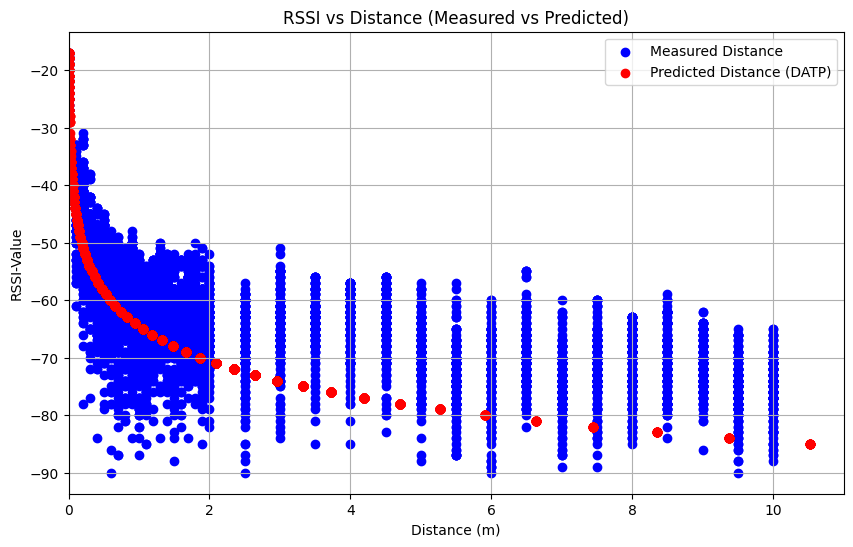

In [6]:
plt.figure(figsize=(10, 6))

# Scatter plots with Distance on the x-axis and RSSI on the y-axis
plt.scatter(df['Distance'], df['RSSI-Value'], color='blue', label='Measured Distance')
plt.scatter(df['DATP'], df['RSSI-Value'], color='red', label='Predicted Distance (DATP)')

plt.xlabel('Distance (m)')
plt.ylabel('RSSI-Value')
plt.title('RSSI vs Distance (Measured vs Predicted)')
plt.xlim(0, 11)

plt.legend()
plt.grid(True)
plt.show()

In this step the DATP is compared visually against for the first 3380 datapoints (e.g., 0 - 2m).

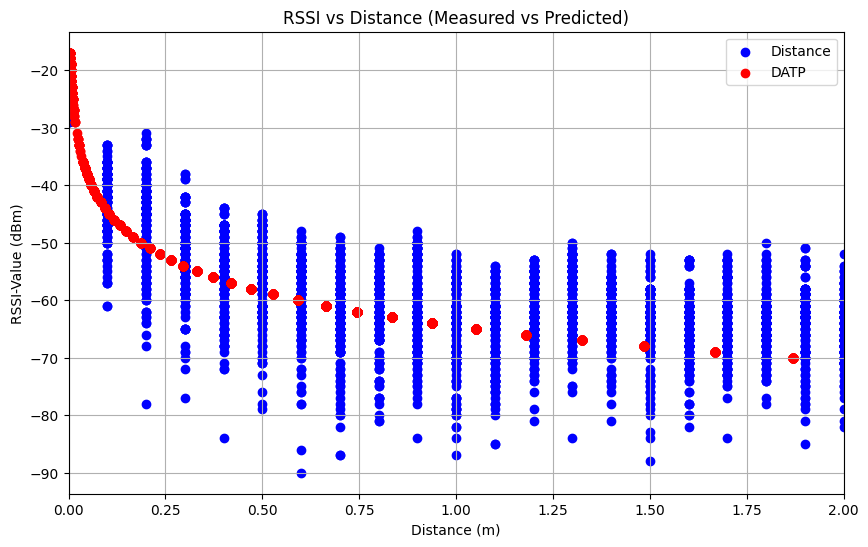

In [7]:
plt.figure(figsize=(10, 6))

# Flip the axes: Distance on x-axis and RSSI on y-axis
plt.scatter(df['Distance'][:3380], df['RSSI-Value'][:3380], color='blue', label='Distance')
plt.scatter(df['DATP'][:3380], df['RSSI-Value'][:3380], color='red', label='DATP')

plt.xlabel('Distance (m)')  # Distance on x-axis
plt.ylabel('RSSI-Value (dBm)')  # RSSI on y-axis
plt.title('RSSI vs Distance (Measured vs Predicted)')

plt.xlim(0, 2)

plt.legend()
plt.grid(True)
plt.show()


Assess statistical differences between actual distance and paper distance:



In [8]:
difference = df['Distance'] - df['DATP']
mean_difference = round(difference.mean(), 2)
median_difference = round(difference.median(), 2)
std_difference = round(difference.std(), 2)
min_difference = round(difference.min(), 2)
max_difference = round(difference.max(), 2)

print(f"Mean difference: {mean_difference} m")
print(f"Median difference: {median_difference} m")
print(f"Minimum difference: {min_difference} m")
print(f"Maximum difference: {max_difference} m")

Mean difference: 1.63 m
Median difference: 0.76 m
Minimum difference: -18.11 m
Maximum difference: 8.95 m


## Statistical Modeling - Regression Analysis

Express the exact numerical distance with the RSSI values from the data.



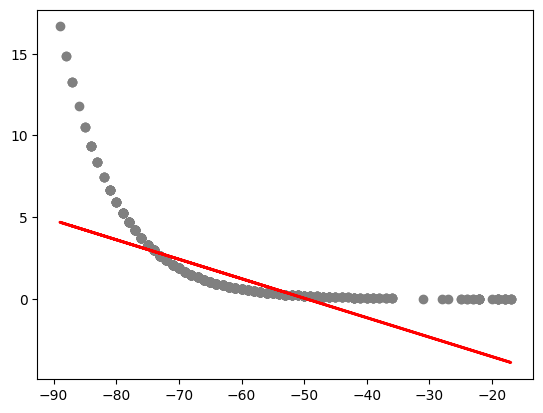

In [9]:
X = subset_df['RSSI-Value']
y = subset_df['DATP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_pred = model.predict(sm.add_constant(X_test))

plt.scatter(X_test, y_test, color='gray')
plt.plot(X_test, y_pred, color='red', linewidth=2)
plt.show()

Diagnostic Plots for Linear Model Assumptions


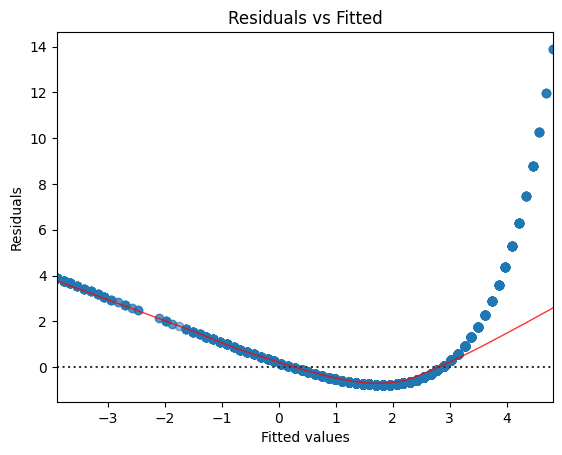

In [10]:
plot_lm_1, ax = plt.subplots()

sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True, ax=ax,
              scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

ax.set_title('Residuals vs Fitted')
ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


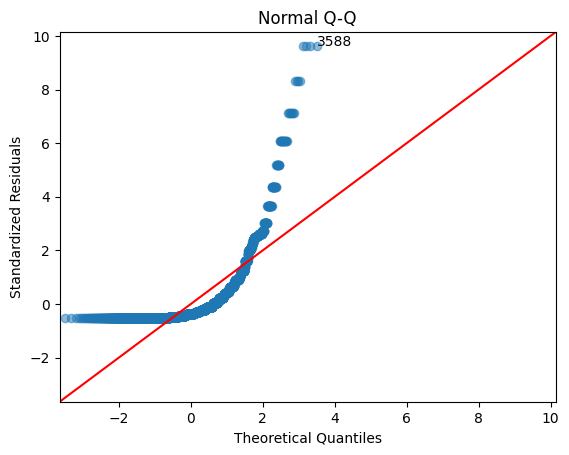

In [11]:
# Normal Q-Q plot
from statsmodels.graphics.gofplots import ProbPlot

model_norm_residuals = model.get_influence().resid_studentized_internal
model_fitted_y = model.fittedvalues
model_residuals = model.resid
model_norm_residuals = model.get_influence().resid_studentized_internal
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))
model_abs_resid = np.abs(model_residuals)
model_leverage = model.get_influence().hat_matrix_diag
model_cooks = model.get_influence().cooks_distance[0]

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1)
plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals')

abs_norm_resid = np.flip(np.argsort(np.abs(model_norm_residuals)), 0)
abs_norm_resid_top = abs_norm_resid[:1]
for r, i in enumerate(abs_norm_resid_top):
    plot_lm_2.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   model_norm_residuals[i]))

plt.show()

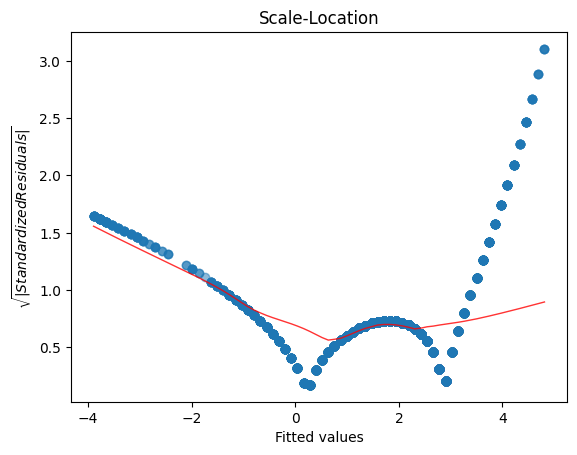

In [12]:
# Scale-Location Plot
plot_lm_3 = plt.figure()
plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(x=model_fitted_y,y= model_norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$')


abs_sq_norm_resid = np.flip(np.argsort(model_norm_residuals_abs_sqrt), 0)
abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]

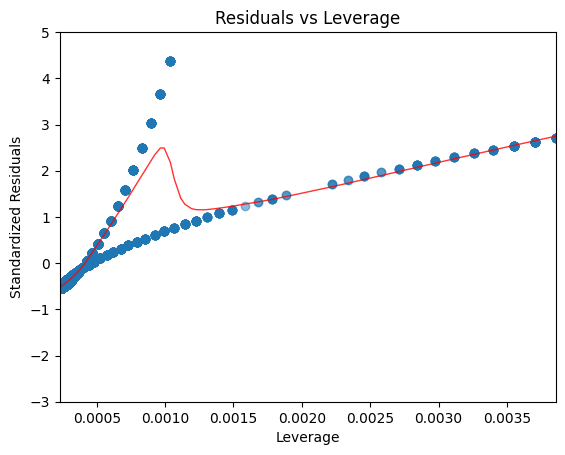

In [13]:
# Residuals vs Leverage
plot_lm_4 = plt.figure()
plt.scatter(model_leverage, model_norm_residuals, alpha=0.5)
sns.regplot(x=model_leverage,y= model_norm_residuals,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plot_lm_4.axes[0].set_xlim(min(model_leverage), max(model_leverage))
plot_lm_4.axes[0].set_ylim(-3, 5)
plot_lm_4.axes[0].set_title('Residuals vs Leverage')
plot_lm_4.axes[0].set_xlabel('Leverage')
plot_lm_4.axes[0].set_ylabel('Standardized Residuals')

leverage_top_3 = np.flip(np.argsort(model_cooks), 0)[:3]
for i in leverage_top_3:
    plot_lm_4.axes[0].annotate(i,
                                 xy=(model_leverage[i],
                                     model_norm_residuals[i]))

plt.show()

## Exponential Regression


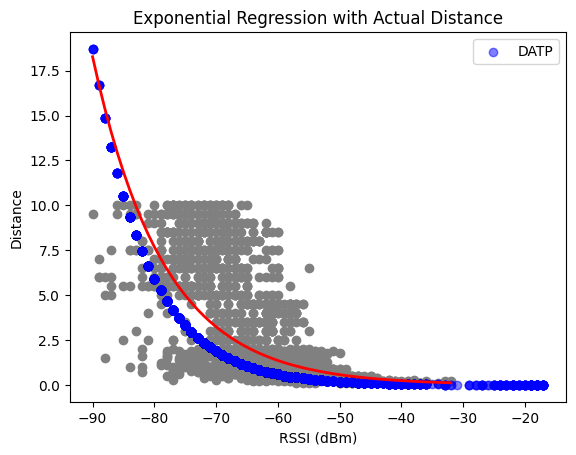

MSE:  7.737280542451424
R2:  0.18305278845594009


In [14]:
X = subset_df['RSSI-Value'].values.reshape(-1, 1).astype(float)
y = subset_df['Distance'].values.reshape(-1, 1).astype(float)

# Remove any non-positive values of y since we will be taking the logarithm
positive_indices = y > 0
X = X[positive_indices].reshape(-1, 1)
y = y[positive_indices].reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Log-transform the y-values
y_train_log = np.log(y_train)

# Fit the model
model = sm.OLS(y_train_log, sm.add_constant(X_train)).fit()

# Predict using the model
y_pred_log = model.predict(sm.add_constant(X_test))
y_pred = np.exp(y_pred_log)  # Convert back to the original scale
# Plotting the results
plt.scatter(X_test, y_test, color='gray')
sorted_indices = X_test.flatten().argsort()
plt.plot(X_test[sorted_indices], y_pred[sorted_indices], color='red', linewidth=2)
plt.xlabel('RSSI (dBm)')
plt.ylabel('Distance')
plt.title('Exponential Regression with Actual Distance')
plt.scatter(subset_df['RSSI-Value'], subset_df['DATP'], color='blue', label='DATP', alpha=0.5)
plt.legend()
plt.show()

# MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)

# R2
r2 = r2_score(y_test, y_pred)
print("R2: ", r2)

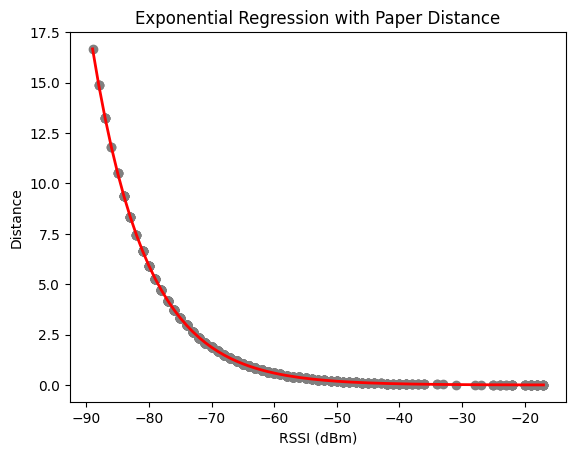

MSE:  1.1448306935485012e-26
R2:  1.0


In [15]:
X = subset_df['RSSI-Value'].values.reshape(-1, 1).astype(float)
y = subset_df['DATP'].values.reshape(-1, 1).astype(float)

positive_indices = y > 0
X = X[positive_indices].reshape(-1, 1)
y = y[positive_indices].reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train_log = np.log(y_train)

model = sm.OLS(y_train_log, sm.add_constant(X_train)).fit()

y_pred_log = model.predict(sm.add_constant(X_test))
y_pred = np.exp(y_pred_log)

plt.scatter(X_test, y_test, color='gray')
sorted_indices = X_test.flatten().argsort()
plt.plot(X_test[sorted_indices], y_pred[sorted_indices], color='red', linewidth=2)
plt.xlabel('RSSI (dBm)')
plt.ylabel('Distance')
plt.title('Exponential Regression with Paper Distance')
plt.show()

# MSE
mse = mean_squared_error(y_test, y_pred)
print("MSE: ", mse)

# R2
r2 = r2_score(y_test, y_pred)
print("R2: ", r2)

# Statistical Modeling - Classification Analysis


Classify the category in which the distance falls to instead of its precise numerical value.

In [16]:
bins = [0, 1, 2, 4, 10, float('inf')]  # the last bin captures everything above 10
labels = ['0-1m', '1-2m', '2-4m', '4-10m', '10+m']

# convert the distance values to float
subset_df['Distance'] = subset_df['Distance'].astype(float)

subset_df['Distance Category'] = pd.cut(subset_df['Distance'], bins=bins, labels=labels, right=False)

X = subset_df[['RSSI-Value']]  # Features
y = subset_df['Distance Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Random Forest Classification

In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred = rf.predict(X_test_scaled)
print("Decision Tree Accuracy:", str(round(accuracy_score(y_test, y_pred) * 100, 2)) + "%")
print(classification_report(y_test, y_pred))

Decision Tree Accuracy: 56.16%
              precision    recall  f1-score   support

        0-1m       0.70      0.65      0.67       310
        1-2m       0.41      0.48      0.44       290
        10+m       0.00      0.00      0.00        32
        2-4m       0.00      0.00      0.00       107
       4-10m       0.59      0.77      0.67       349

    accuracy                           0.56      1088
   macro avg       0.34      0.38      0.36      1088
weighted avg       0.50      0.56      0.52      1088



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Decision Tree Classification

In [19]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
y_pred = dt.predict(X_test_scaled)
print("Decision Tree Accuracy:", str(round(accuracy_score(y_test, y_pred) * 100, 2)) + "%")
print(classification_report(y_test, y_pred))

Decision Tree Accuracy: 56.16%
              precision    recall  f1-score   support

        0-1m       0.70      0.65      0.67       310
        1-2m       0.41      0.48      0.44       290
        10+m       0.00      0.00      0.00        32
        2-4m       0.00      0.00      0.00       107
       4-10m       0.59      0.77      0.67       349

    accuracy                           0.56      1088
   macro avg       0.34      0.38      0.36      1088
weighted avg       0.50      0.56      0.52      1088



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Naive Bayes Classifier


In [20]:
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)
y_pred = nb.predict(X_test_scaled)
print("Naive Bayes Accuracy:", str(round(accuracy_score(y_test, y_pred) * 100, 2)) + "%")
print(classification_report(y_test, y_pred, zero_division=0))

Naive Bayes Accuracy: 56.62%
              precision    recall  f1-score   support

        0-1m       0.82      0.55      0.65       310
        1-2m       0.42      0.67      0.51       290
        10+m       0.00      0.00      0.00        32
        2-4m       0.00      0.00      0.00       107
       4-10m       0.61      0.72      0.66       349

    accuracy                           0.57      1088
   macro avg       0.37      0.39      0.37      1088
weighted avg       0.54      0.57      0.54      1088



### Multilayer Perceptron (MLP) Classifier


In [21]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp.fit(X_train_scaled, y_train)
y_pred = mlp.predict(X_test_scaled)
print("MLP Classifier Accuracy:", str(round(accuracy_score(y_test, y_pred) * 100, 2)) + "%")
print(classification_report(y_test, y_pred))

MLP Classifier Accuracy: 57.54%
              precision    recall  f1-score   support

        0-1m       0.77      0.62      0.69       310
        1-2m       0.43      0.57      0.49       290
        10+m       0.00      0.00      0.00        32
        2-4m       0.00      0.00      0.00       107
       4-10m       0.59      0.77      0.67       349

    accuracy                           0.58      1088
   macro avg       0.36      0.39      0.37      1088
weighted avg       0.52      0.58      0.54      1088



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Cross Validation for Model Assessment


Random Forest - Training R-squared: 0.3856, Cross-validated R-squared: 0.3690, Diff: 0.0166
Random Forest - Test Accuracy: 0.3199
Decision Tree - Training R-squared: 0.3863, Cross-validated R-squared: 0.3687, Diff: 0.0176
Decision Tree - Test Accuracy: 0.3199
Naive Bayes - Training R-squared: 0.1419, Cross-validated R-squared: 0.1022, Diff: 0.0397
Naive Bayes - Test Accuracy: 0.5662
MLP - Training R-squared: 0.3915, Cross-validated R-squared: 0.3721, Diff: 0.0194
MLP - Test Accuracy: 0.3125


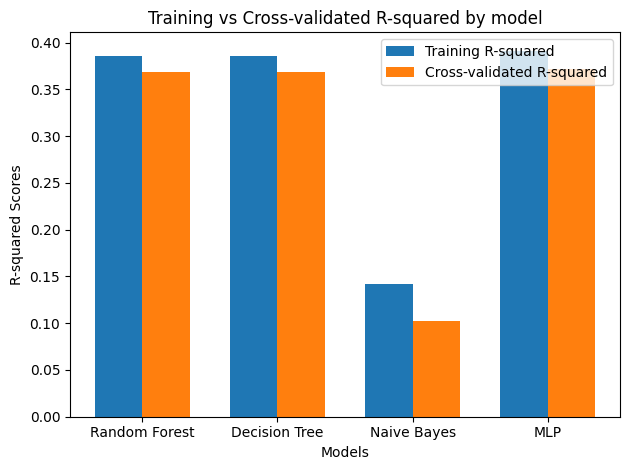

In [22]:
models = [RandomForestRegressor(), DecisionTreeRegressor(), GaussianNB(), MLPRegressor()]
model_names = ['Random Forest', 'Decision Tree', 'Naive Bayes', 'MLP']

testing_r2_scores = []
cross_val_r2_scores = []

for model, name in zip(models, model_names):
    # Encode the target variable
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded = label_encoder.transform(y_test)

    # Fit the model on the training data with encoded target variable
    model.fit(X_train_scaled, y_train_encoded)
    y_test_pred = model.predict(X_test_scaled) # Predict on the test data
    testing_r2 = r2_score(y_test_encoded, y_test_pred)
    testing_r2_scores.append(testing_r2)

    # Perform cross-validation and calculate the mean cross-validated R-squared
    cross_val_r2 = cross_val_score(model, X_train_scaled, y_train_encoded, cv=5, scoring='r2')
    cross_val_r2_mean = np.mean(cross_val_r2)
    cross_val_r2_scores.append(cross_val_r2_mean)
    print(f'{name} - Training R-squared: {testing_r2:.4f}, Cross-validated R-squared: {cross_val_r2_mean:.4f}, Diff: {testing_r2 - cross_val_r2_mean:.4f}')
    accuracy = np.mean(y_test_encoded == y_test_pred.astype(int))
    print(f'{name} - Test Accuracy: {accuracy:.4f}')



x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, testing_r2_scores, width, label='Training R-squared')
rects2 = ax.bar(x + width/2, cross_val_r2_scores, width, label='Cross-validated R-squared')

ax.set_xlabel('Models')
ax.set_ylabel('R-squared Scores')
ax.set_title('Training vs Cross-validated R-squared by model')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()

fig.tight_layout()

plt.show()